# Demand Forecasting with Censored Likelihood

In this notebook we will explore the use of censored likelihood for demand forecasting. 

**Business Problem**: Let us assume we have a store with a single product. We want to forecast the (true!) demand for this product for the next 30 days using historical data. The historical data consists of the daily sales of the product for the last year (approximately). An important challenge is that our historical sales data is censored. This means that we only observe the sales of the product when it is in stock. If the product is out of stock, we do not observe any sales. This includes when the product is not available in the store or when we sold out of the product.

In many practical scenarios, the demand data is censored as described above. Nevertheless, we usually use classical forecasting methods like ARIMA, ETS, or Croston's method (for intermittent demand) to forecast the demand. These methods do not take into account the censored nature of the data. In this notebook, we will explore the use of censored likelihood for demand forecasting. We describe the data generating process from the business problem above and compare the performance of the censored likelihood method with the classical forecasting methods.

For an introduction on how to model censored data with Bayesian methods, see the blog post ["Bayesian Censoring Data Modeling"](https://juanitorduz.github.io/censoring/) and the PyMC example notebook ["Bayesian regression with truncated or censored data"](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-truncated-censored-regression.html)

**Remark**: This idea was motivated by the great blog post ["Modeling Anything With First Principles: Demand under extreme stockouts"](https://kylejcaron.github.io/posts/censored_demand/2024-02-06-censored-demand.html) by [Kyle Caron](https://kylejcaron.github.io/) where he uses these techniques to model and balance demand under extreme stockouts and other constraints.

## Prepare Notebook

In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
from jax import random
from numpyro.contrib.control_flow import scan
from numpyro.infer import MCMC, NUTS, Predictive
from pydantic import BaseModel, Field
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Data Generating Process

We are going to simulate the data generating process for the business problem described above:

- We generate the true demand for time series as an auto-regressive $AR(2)$ process  with a seasonal component.
- We generate sales data based on this true demand. The sales are less than or equal to the true demand.
  - We add days where the product is out of stock. We assume that the product is out of stock for 10% of the time.
  - We also put a cap on the sales based on the maximum stock level (i.e. how many products I can have in stock during a day).
  - The range of the demand and sales is a real (`float`) number which can indicate hundreds or thousands of units sold.

The following class contained the parameters for the data generating process.

In [2]:
class DataGeneratingProcessParams(BaseModel):
    """Parameters for the data generating process."""

    n: int = Field(..., description="Number of samples")
    ar_1_demand: float = Field(..., description="AR(1) coefficient for the demand")
    ar_2_demand: float = Field(..., description="AR(2) coefficient for the demand")
    seasonal_frequency_demand: int = Field(
        ..., description="Seasonal frequency for the demand", gt=0
    )
    seasonal_amplitude_demand: float = Field(
        ..., description="Amplitude of the seasonality"
    )
    constant_term_demand: float = Field(..., description="Constant term for the demand")
    demand_sales_delta: float = Field(
        ..., description="Delta between demand and sales", gt=0
    )
    sigma_noise_demand: float = Field(
        ..., description="Standard deviation of the noise for the demand", gt=0
    )
    sigma_noise_sales: float = Field(
        ..., description="Standard deviation of the noise for the sales", gt=0
    )
    is_available_rate: float = Field(
        ..., description="Rate of availability of the product", ge=0, le=1
    )
    max_caparity: float = Field(
        ...,
        description="Maximum capacity of the product (max possible sales per period)",
        gt=0,
    )


data_params = DataGeneratingProcessParams(
    n=180,
    ar_1_demand=0.6,
    ar_2_demand=0.3,
    seasonal_frequency_demand=7,
    seasonal_amplitude_demand=0.6,
    constant_term_demand=0.2,
    demand_sales_delta=0.25,
    sigma_noise_demand=0.3,
    sigma_noise_sales=0.5,
    is_available_rate=0.80,
    max_caparity=2.2,
)

We now use these parameters to simulate the data.

In [3]:
def demand_sales_dgp(rng_key, params):
    """Simulate the demand and sales for a product.

    We model the demand as an AR(2) process with a seasonal component. The sales are
    generated by adding noise to the demand and subtracting the delta between demand
    and sales. The sales are also subject to availability capacity constraints.

    Parameters
    ----------
    rng_key : jax.random.PRNGKey
        Random key for reproducibility
    params : DataGeneratingProcessParams
        Parameters for the data generating process.

    Returns
    -------
    Tuple
        Tuple with the time, demand, sales, sales observed, and availability data.
    """
    t = jnp.arange(start=0, stop=params.n, step=1)
    demand = 2 * jnp.ones_like(t, dtype=jnp.float32)
    sales = jnp.zeros_like(t, dtype=jnp.float32)
    sales_obs = jnp.zeros_like(t, dtype=jnp.float32)

    rng_key, rng_subkey = random.split(rng_key)
    noise_demand = params.sigma_noise_demand * random.normal(
        rng_subkey, shape=(t.size,)
    )

    rng_key, rng_subkey = random.split(rng_key)
    noise_sales = params.sigma_noise_sales * random.normal(rng_subkey, shape=(t.size,))

    rng_key, rng_subkey = random.split(rng_key)
    is_available = random.bernoulli(
        rng_subkey, params.is_available_rate, shape=(t.size,)
    ).astype(jnp.float32)

    for i in range(2, t.size):
        demand_i = (
            params.ar_1_demand * demand[i - 1]
            + params.ar_2_demand * demand[i - 2]
            + params.seasonal_amplitude_demand * jnp.sin(2 * jnp.pi * t[i] / 7)
            + params.constant_term_demand
            + noise_demand[i]
        )
        demand_i = jnp.maximum(demand_i, 0)
        demand = demand.at[i].set(demand_i)  # noqa

        sales_i = demand[i] + noise_sales[i] - params.demand_sales_delta
        sales_i = jnp.minimum(sales_i, demand_i)
        sales_i = jnp.maximum(sales_i, 0)
        sales_i_obs = is_available[i] * sales_i
        sales_i_obs = jnp.minimum(sales_i_obs, params.max_caparity)
        sales = sales.at[i].set(sales_i)  # noqa
        sales_obs = sales_obs.at[i].set(sales_i_obs)  # noqa

    return t, demand, sales, sales_obs, is_available


rng_key, rng_subkey = random.split(rng_key)
t, demand, sales, sales_obs, is_available = demand_sales_dgp(rng_subkey, data_params)

Let's visualize the true demand and the sales data.

- The <span style="color:black">black</span> time series represents the true demand.
- The <span style="color:blue">blue</span> time series represents the sales data without any stock restrictions.
- The <span style="color:orange">orange</span> time series represents the observed sales data (the only data available to generate forecast).
- the <span style="color:gray">gray</span> time series represents the out-of-stock days.

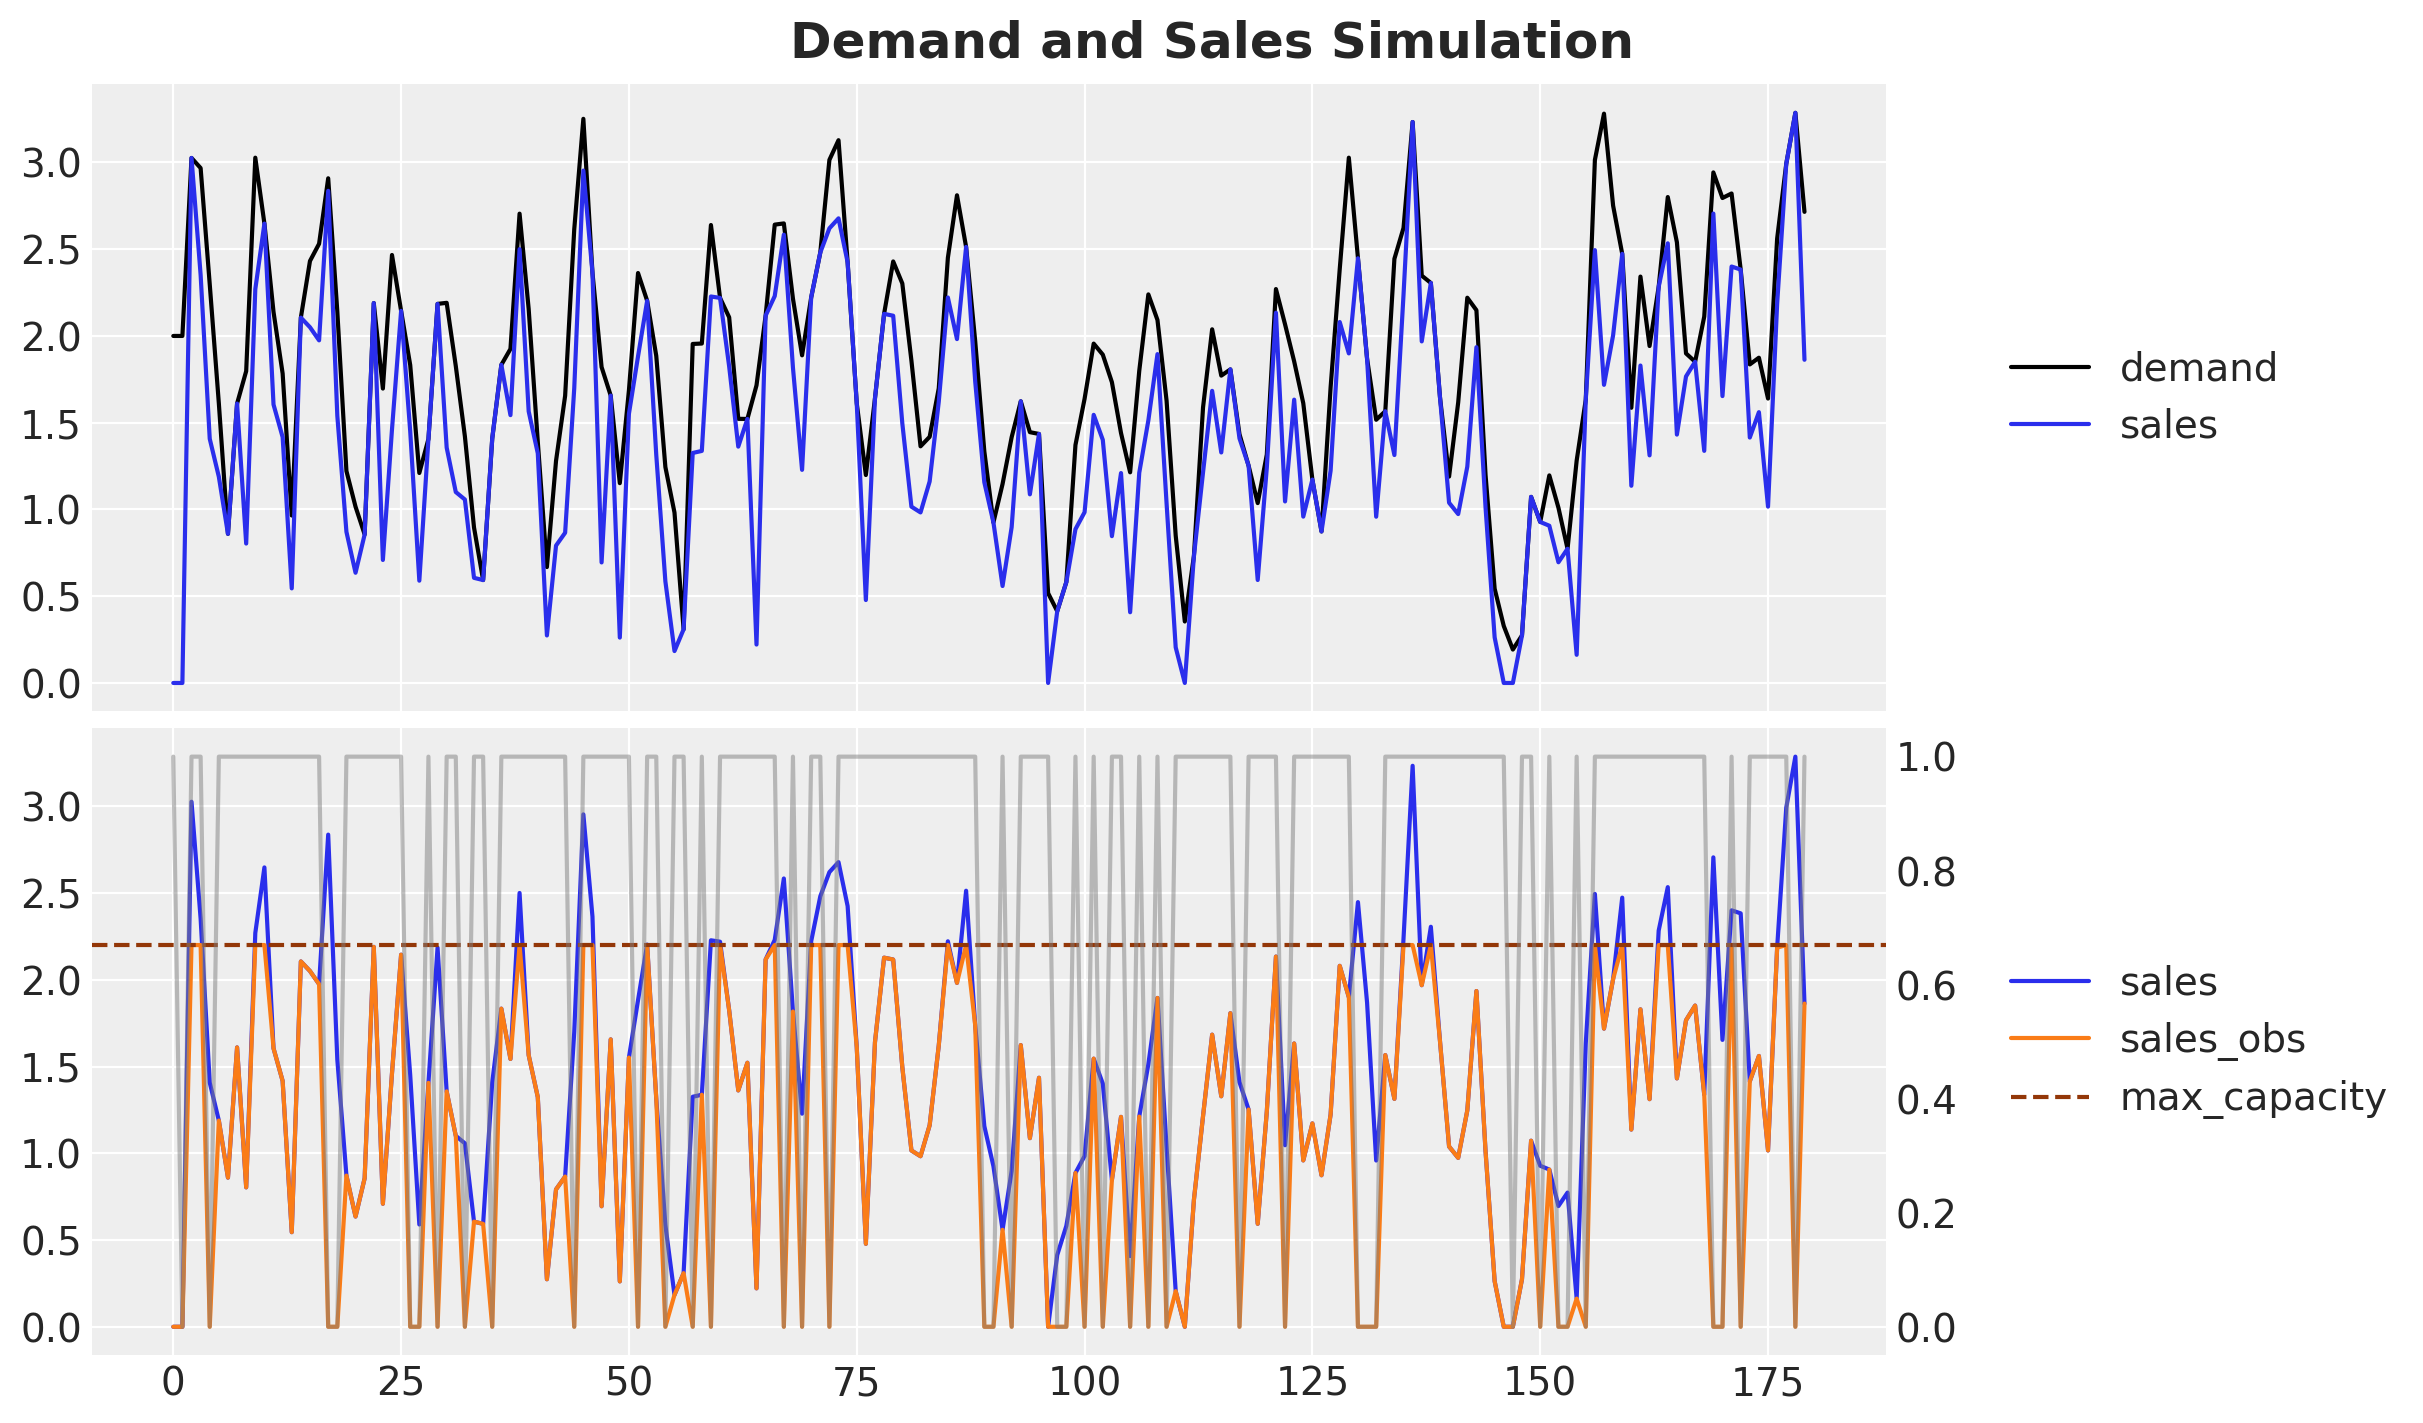

In [4]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(12, 7),
    sharex=True,
    sharey=True,
    layout="constrained",
)

ax[0].plot(t, demand, c="black", label="demand")
ax[0].plot(t, sales, c="C0", label="sales")
ax[0].legend(loc="center left", bbox_to_anchor=(1.05, 0.5))

ax[1].plot(t, sales, c="C0", label="sales")
ax[1].plot(t, sales_obs, c="C1", label="sales_obs")
ax1_twin = ax[1].twinx()
ax1_twin.plot(t, is_available, c="gray", alpha=0.5, label="is_available")
ax[1].axhline(
    data_params.max_caparity, color="C4", linestyle="--", label="max_capacity"
)
ax1_twin.grid(None)
ax[1].legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
fig.suptitle("Demand and Sales Simulation", fontsize=18, fontweight="bold");

## Train-Test Split

We split the data into a training set and a test set.

In [5]:
forecast_horizon = 30

t_train = t[:-forecast_horizon]
demand_train = demand[:-forecast_horizon]
sales_train = sales[:-forecast_horizon]
sales_obs_train = sales_obs[:-forecast_horizon]
is_available_train = is_available[:-forecast_horizon]
max_capacity_train = (sales_obs_train == data_params.max_caparity).astype(int)

t_test = t[-forecast_horizon:]
demand_test = demand[-forecast_horizon:]
sales_test = sales[-forecast_horizon:]
sales_obs_test = sales_obs[-forecast_horizon:]
is_available_test = is_available[-forecast_horizon:]
is_available_test_expected = jnp.ones_like(is_available_test)
max_capacity_test_expected = jnp.zeros_like(sales_obs_test)

## Classical Forecasting Model: ARIMA + Fourier Modes

Let us use an ARIMA model as a baseline model. The ARIMA model is a classical time series model that can capture the auto-regressive and seasonal components (through the Fourier modes in this example). In general, it performs well as an out-of-the-box model for time series forecasting.

Let's look into the (partial) autocorrelation function of the observed sales data to determine the order of the ARIMA model.

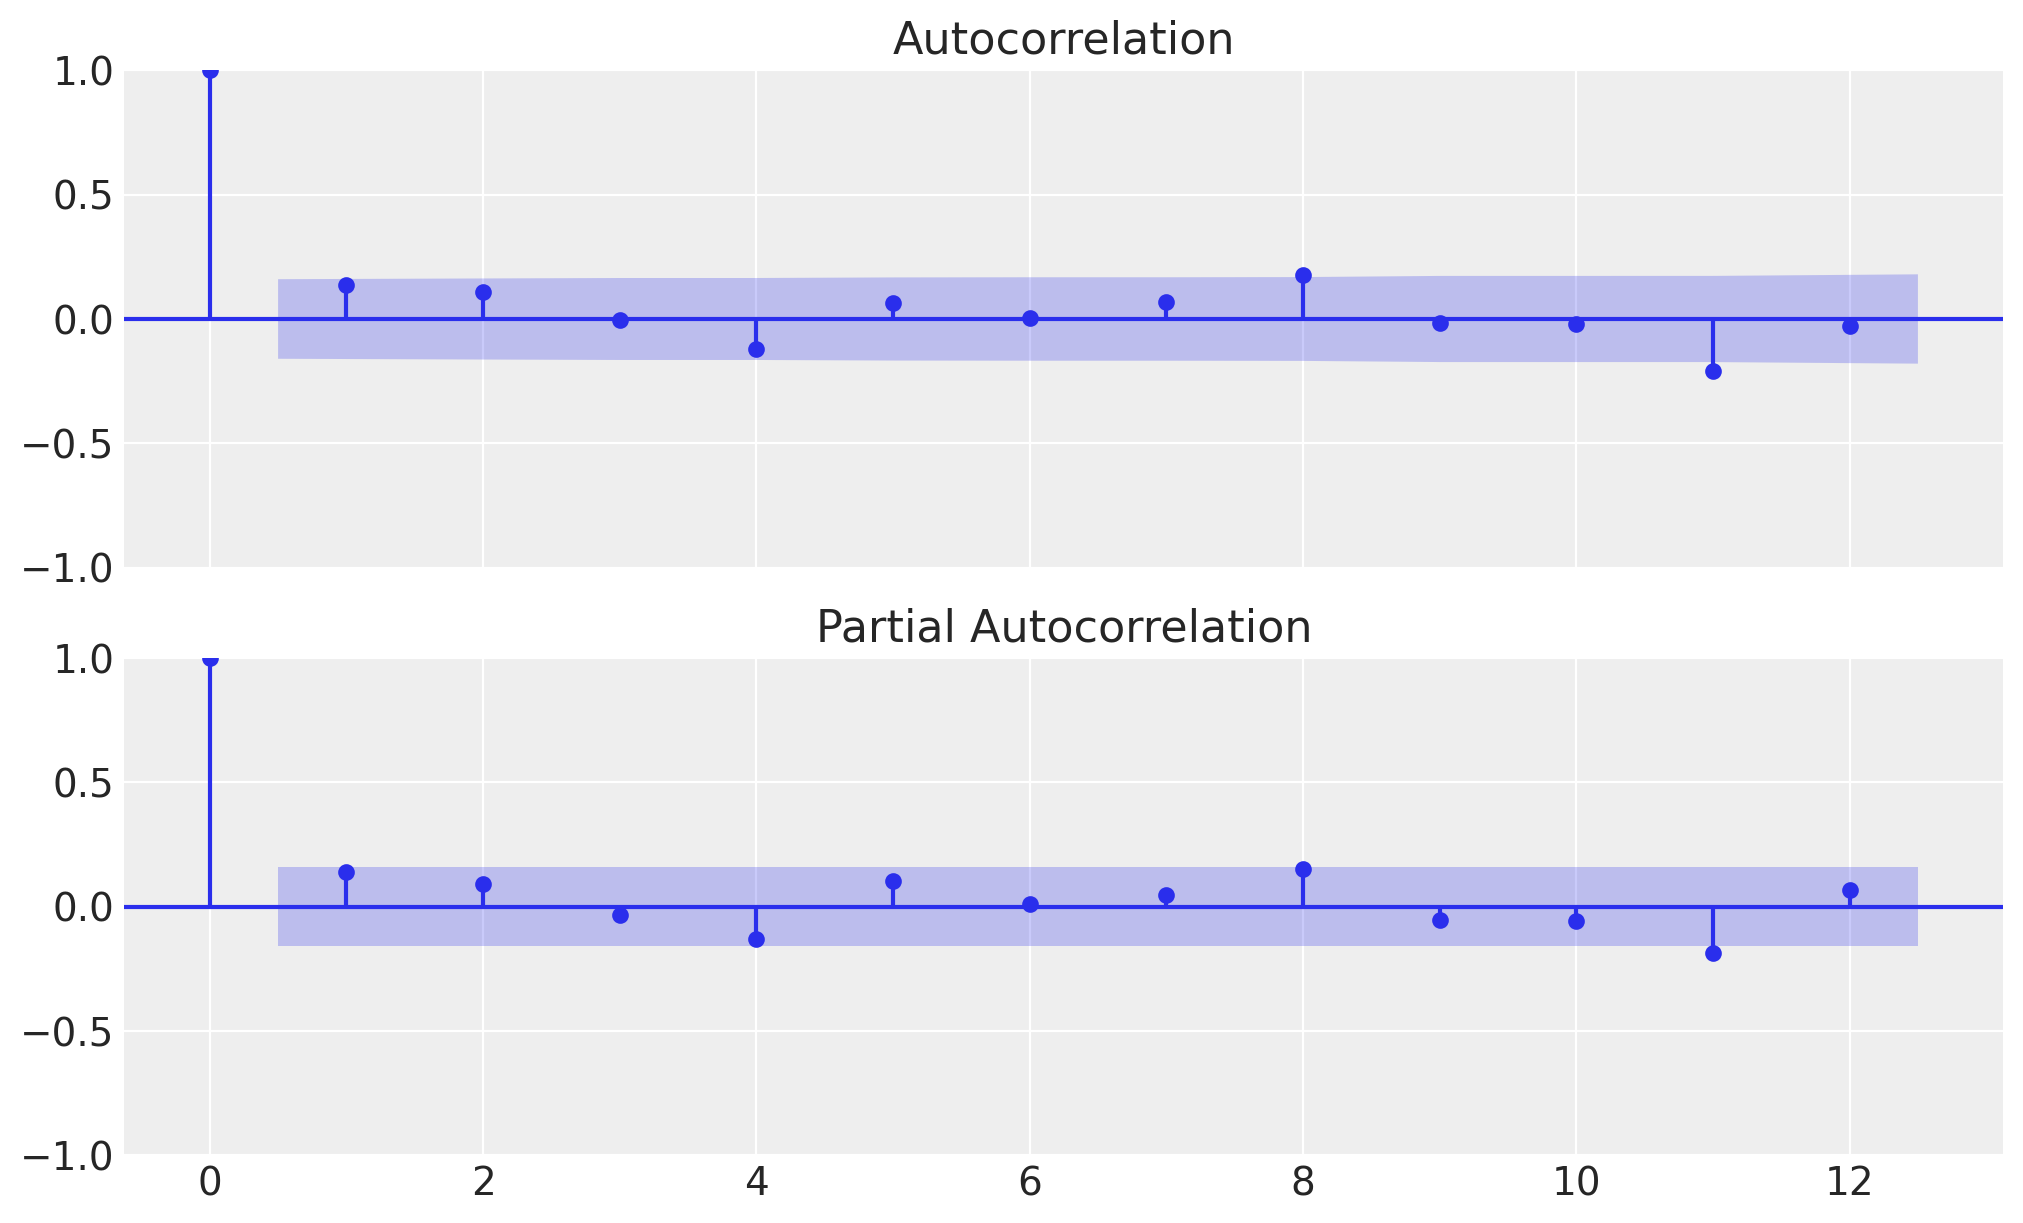

In [6]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, sharex=True, sharey=True, figsize=(10, 6), layout="constrained"
)

_ = plot_acf(sales_obs_train, lags=12, ax=ax[0])
_ = plot_pacf(sales_obs_train, lags=12, ax=ax[1])

From the plot, we can see that the partial autocorrelation function (PACF) has a significant spike at lag #2#. This suggests that the ARIMA model should have an auto-regressive component of order $2$. 

In addition, by simply looking at the sales data, we can see that there is a weekly (7 days) seasonal component. We can capture this seasonal component by adding Fourier modes to the ARIMA model. Let's generate such features.

In [7]:
# order of the Fourier features
n_order = 2  # this implies we will have 4 features (sin and cos for order 1 and 2)

fourier_features_df = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * t * order / 7)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

fourier_features_train_df = fourier_features_df.iloc[: len(t_train)]
fourier_features_test_df = fourier_features_df.iloc[len(t_train) :]

These features look as follows:

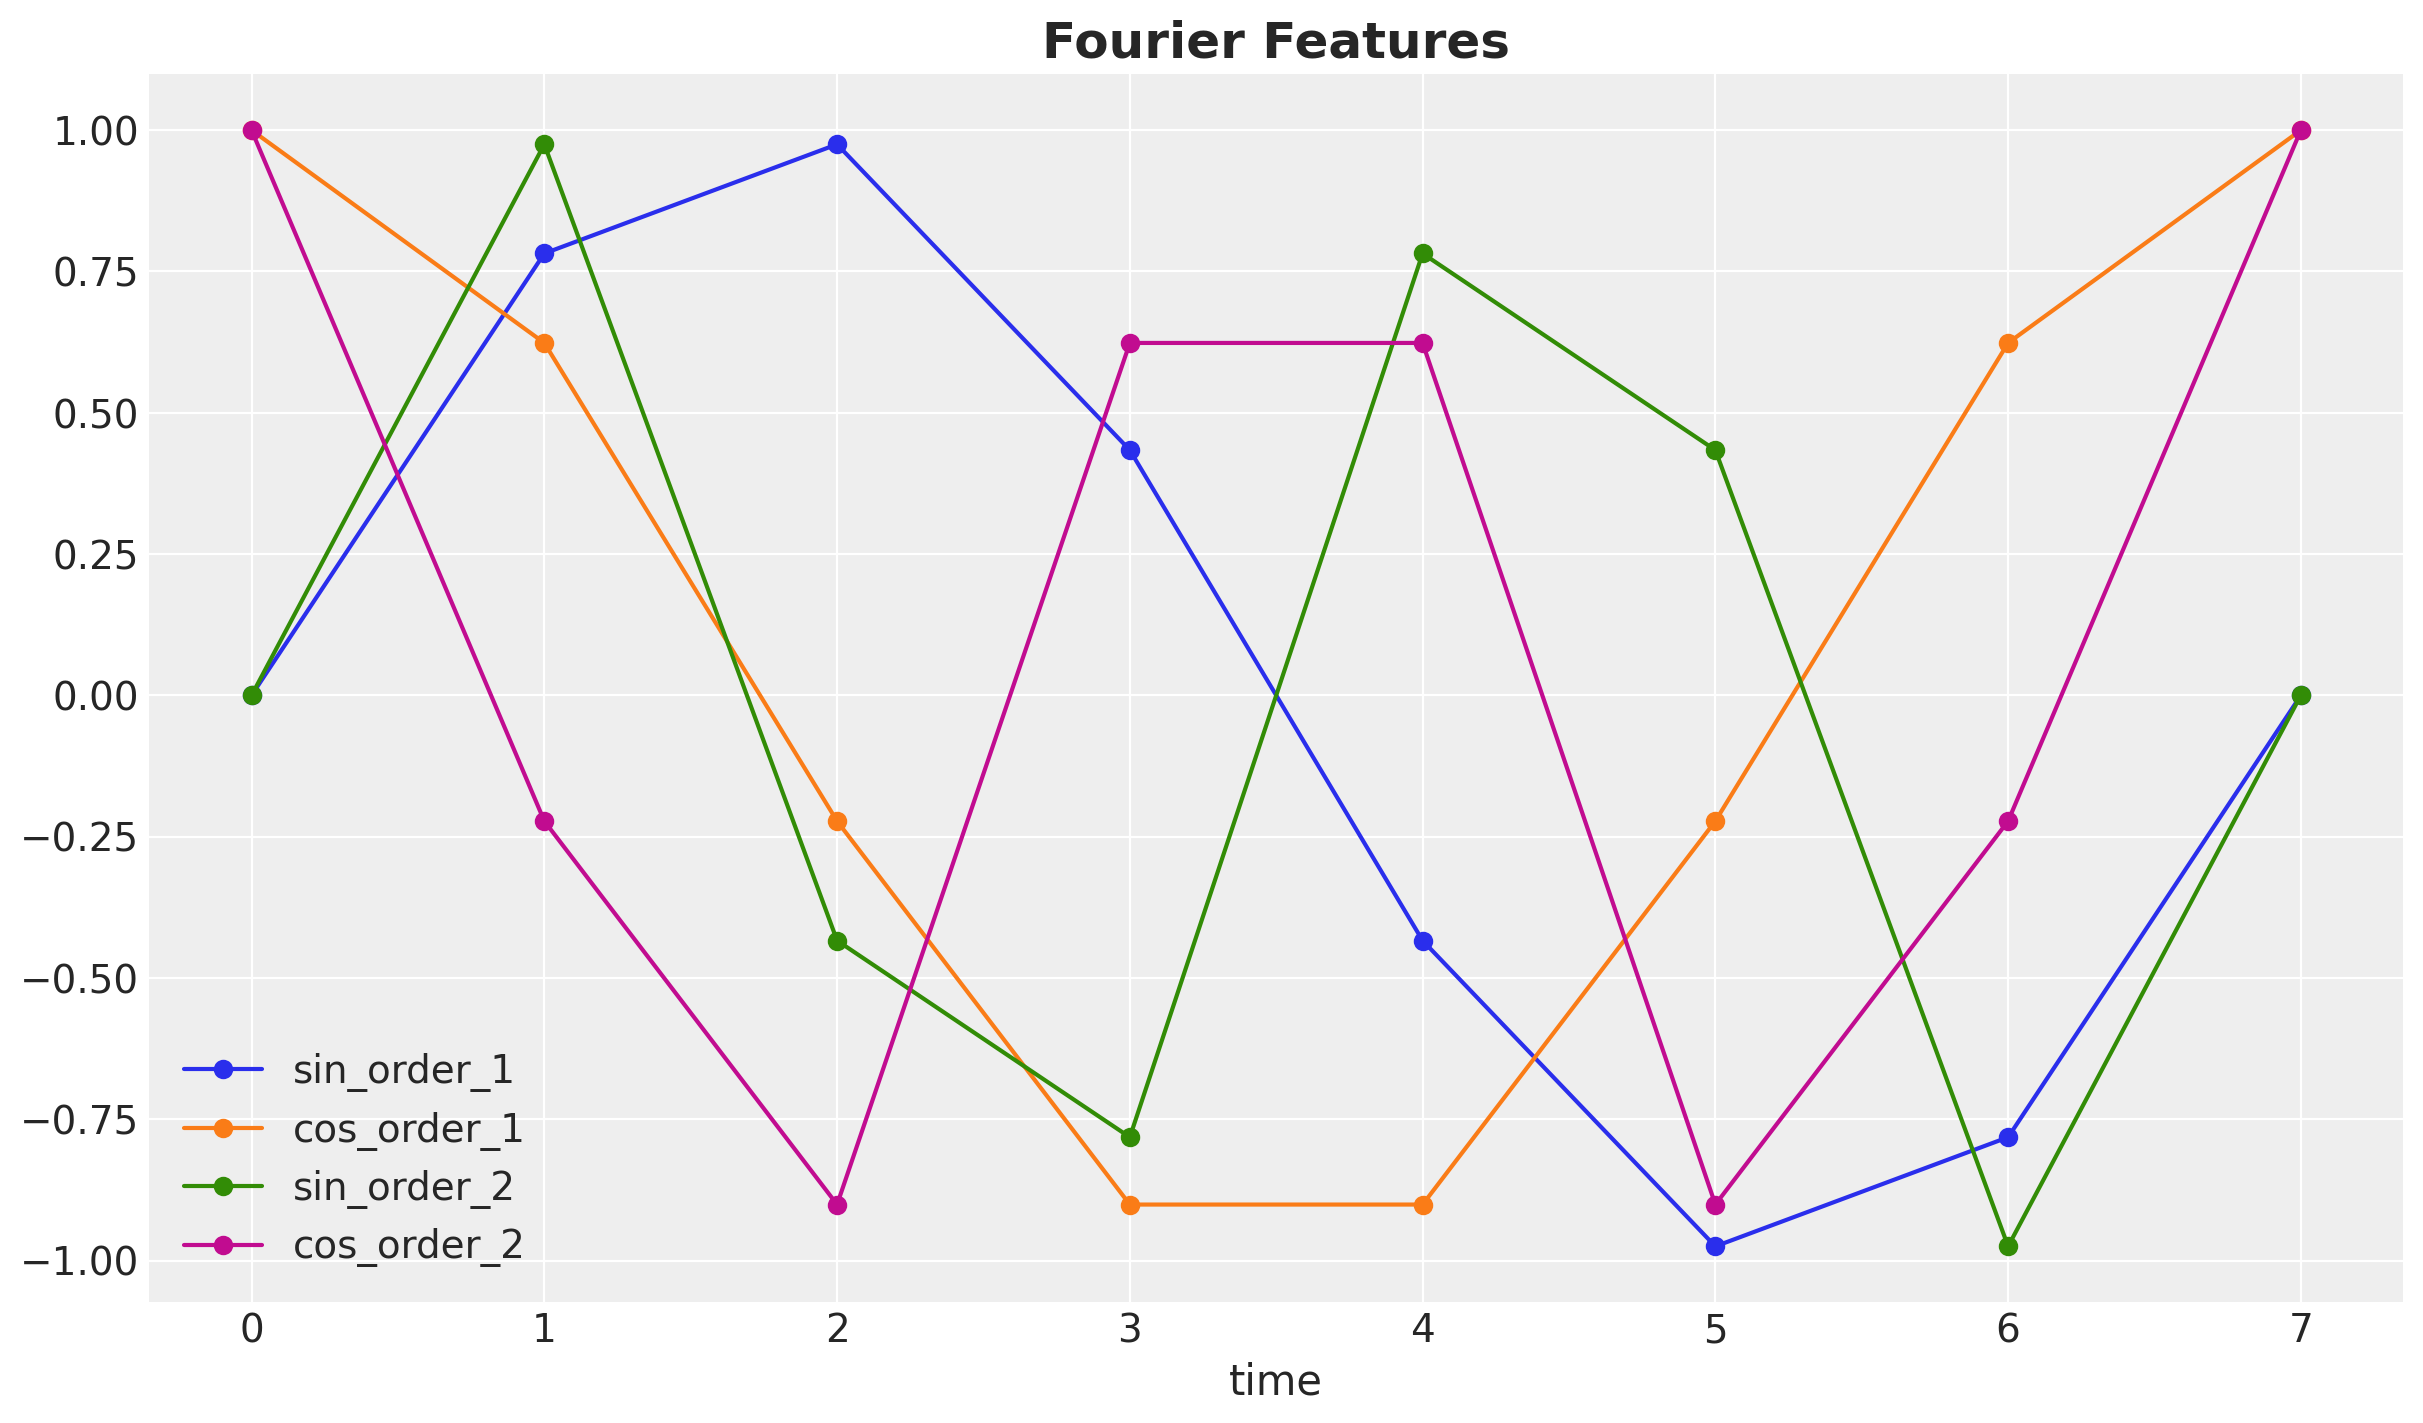

In [8]:
fig, ax = plt.subplots()
fourier_features_df.head(8).plot(marker="o", ax=ax)
ax.set(xlabel="time", ylabel=None)
ax.set_title("Fourier Features", fontsize=18, fontweight="bold");

We also do a train-test split of these seasonal features.

In [9]:
fourier_features = jnp.array(fourier_features_df.to_numpy(), dtype=jnp.float32)

fourier_features_train = fourier_features[:-forecast_horizon]
fourier_features_test = fourier_features[-forecast_horizon:]

Next, we prepare the dataframe of exogenous variables for the ARIMA model. We include the seasonal features and out-of-stock indicator (`is_available`).

**Remark**: Adding the out-of-stock indicator as an exogenous variable is a simple (maybe too simple?) way to "incorporate" the censored nature of the data into the ARIMA model. This is not the best way to model censored data, but it is a simple way to show the difference between the classical and the censored likelihood method.

In [10]:
x_train_df = fourier_features_train_df
x_train_df = x_train_df.assign(is_available=is_available_train)

x_test_df = fourier_features_test_df
x_test_df = x_test_df.assign(is_available=is_available_test_expected)

We are ready to fit the model:

In [11]:
model = ARIMA(
    endog=np.asarray(sales_obs_train),
    exog=x_train_df,
    order=(2, 0, 0),
)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  150
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -103.391
Date:                Sat, 20 Apr 2024   AIC                            224.781
Time:                        21:44:12   BIC                            251.877
Sample:                             0   HQIC                           235.789
                                - 150                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0196      0.135      0.145      0.884      -0.245       0.285
sin_order_1      0.2690      0.061      4.439      0.000       0.150       0.388
cos_order_1     -0.3075      0.064     -4.791      0.000      -0.433      -0.182
sin_order_2      0.0054      0.053      0.101      0.920      -0.099       0.110
cos_order_2      0.0673      0.050      1.344      0.179      -0.031       0.165
is_available     1.3429      0.133     10.130      0.000       1.083       1.603
ar.L1            0.1748      0.083      2.102      0.036       0.012       0.338
ar.L2            0.0931      0.085      1.098      0.272      -0.073       0.259
sigma2           0.2323      0.033      6.953      0.000       0.167       0.298
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.38
Prob(Q):                              0.91   Prob(JB):                         0.18
Heteroskedasticity (H):               0.75   Skew:                            -0.26
Prob(H) (two-sided):                  0.32   Kurtosis:                         2.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Let's look at the forecast for the next 30 days. We plot the point forecast and the $94\\%$ and $50\\%$ confidence intervals.

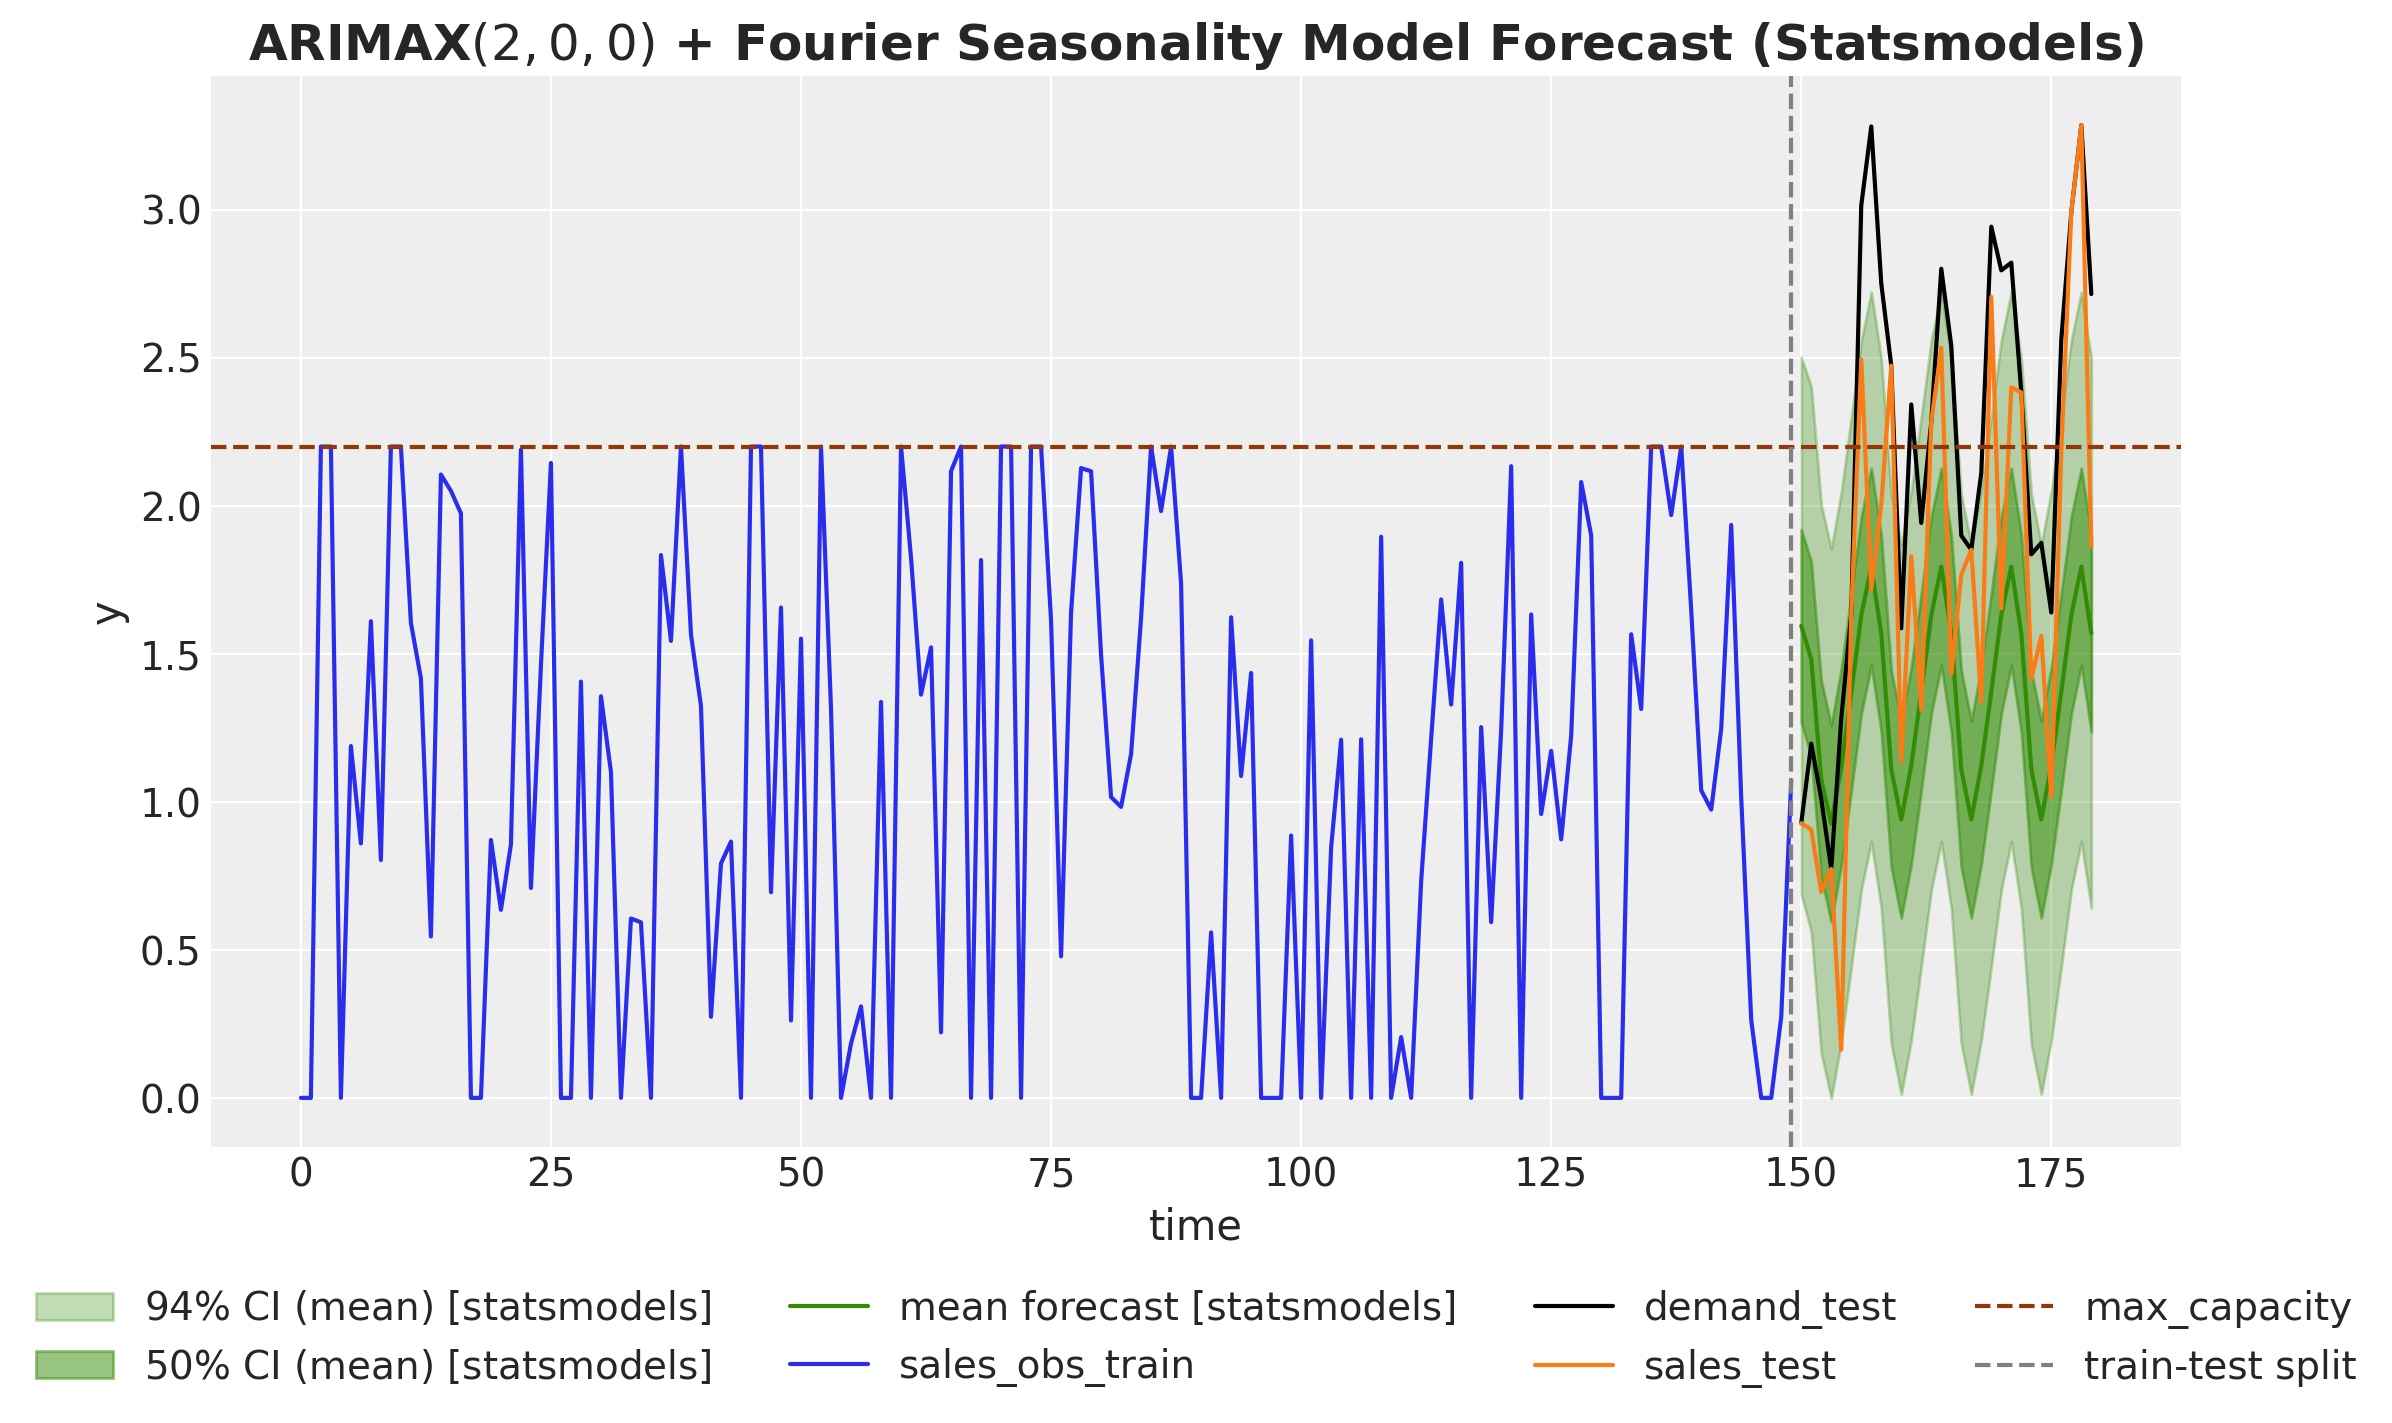

In [12]:
forecast_94_df = result.get_forecast(
    steps=sales_obs_test.size, exog=x_test_df
).summary_frame(alpha=0.06)

forecast_50_df = result.get_forecast(
    steps=sales_obs_test.size, exog=x_test_df
).summary_frame(alpha=0.5)

fig, ax = plt.subplots()
ax.fill_between(
    t_test,
    forecast_94_df["mean_ci_lower"],
    forecast_94_df["mean_ci_upper"],
    color="C2",
    alpha=0.3,
    label=r"$94\%$ CI (mean) [statsmodels]",
)
ax.fill_between(
    t_test,
    forecast_50_df["mean_ci_lower"],
    forecast_50_df["mean_ci_upper"],
    color="C2",
    alpha=0.5,
    label=r"$50\%$ CI (mean) [statsmodels]",
)
ax.plot(t_test, forecast_94_df["mean"], color="C2", label="mean forecast [statsmodels]")
ax.plot(t_train, sales_obs_train, color="C0", label="sales_obs_train")
ax.plot(t_test, demand_test, color="black", label="demand_test")
ax.plot(t_test, sales_test, color="C1", label="sales_test")
ax.axhline(y=data_params.max_caparity, c="C4", linestyle="--", label="max_capacity")
ax.axvline(x=t_train[-1], c="gray", linestyle="--", label="train-test split")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
ax.set(
    xlabel="time",
    ylabel="y",
)
ax.set_title(
    "ARIMAX$(2, 0, 0)$ + Fourier Seasonality Model Forecast (Statsmodels)",
    fontsize=18,
    fontweight="bold",
);

We see that the forecast is very seasonal and does not show a significant trend component as it tries to stay withing the range of the observed sales data. The problem with this forecast it that when planning the stock, we are underestimating the demand. This is because the model does not take into account the censored nature of the data. In real applications, this is ket to decide if we need to rotate or replace products in the store.

## Auto-Regressive Censored Model

In this section, we combine the methods from the blog posts:

- ["Notes on Exponential Smoothing with NumPyro"](https://juanitorduz.github.io/exponential_smoothing_numpyro/)
- ["Notes on an ARMA(1, 1) Model with NumPyro"](https://juanitorduz.github.io/arma_numpyro/)
- ["Bayesian Censoring Data Modeling"](https://juanitorduz.github.io/censoring/)

to implement an auto-regressive (with Fourier modes to model seasonality) censored model for demand forecasting (please refer to these previous blog posts for details on the implementation).

### Model Specification

First, let us write the seasonal component:

In [13]:
def seasonal_component(fourier_features):
    n_modes = fourier_features.shape[1]
    with numpyro.plate("seasonal_order", n_modes):
        beta_mode = numpyro.sample("beta_mode", dist.Normal(loc=0, scale=1))
    return jnp.dot(fourier_features, beta_mode)

Next, we write the censored normal distribution:

In [14]:
def censored_normal(loc, scale, y, censored):
    distribution = dist.Normal(loc=loc, scale=scale)
    ccdf = 1 - distribution.cdf(y)
    numpyro.sample(
        "censored_label", dist.Bernoulli(probs=ccdf).mask(censored == 1), obs=censored
    )
    return numpyro.sample("pred", distribution.mask(censored != 1))

Finally, we add the auto-regressive component and put it all together in the model:

In [15]:
def ar2_seasonal(y, censored, is_available, fourier_features, future=0):
    """Censored AR(2) model with seasonal component via Fourier modes.

    Parameters
    ----------
    y : observed sales data
    censored : censored sales data (when sales reach max capacity)
    is_available : availability indicator (1 if available, 0 otherwise)
    fourier_features : Fourier features for the seasonal component
    future : number of future time steps to forecast
    """
    t_max = y.size
    # --- Priors ---
    # Constant term
    mu = numpyro.sample("mu", dist.Normal(loc=1, scale=1))
    # AR(2) coefficients
    phi_1 = numpyro.sample("phi_1", dist.Normal(loc=0, scale=1))
    phi_2 = numpyro.sample("phi_2", dist.Normal(loc=0, scale=1))
    # Noise
    sigma = numpyro.sample("sigma", dist.HalfNormal(scale=1))

    # --- Parametrization ---
    ## Seasonal component
    seasonal = seasonal_component(fourier_features)

    ## Transition function for AR(2)
    def transition_fn(carry, t):
        y_prev_1, y_prev_2 = carry
        ar_part = phi_1 * y_prev_1 + phi_2 * y_prev_2
        pred_mean = mu + ar_part + seasonal[t]
        # Censored likelihood
        pred = censored_normal(pred_mean, sigma, y[t], censored[t])
        return (pred, y_prev_1), pred

    init = (y[1], y[0])
    timesteps = jnp.arange(t_max - 2 + future)

    # Mask observations where the product is not available
    with numpyro.handlers.mask(mask=is_available[2:] == 1):
        # We condition on the observed data.
        # We also remove the first two time steps because of the AR(2) model
        with numpyro.handlers.condition(data={"pred": y[2:], "censored": censored[2:]}):
            _, preds = scan(transition_fn, init, timesteps)

        # Forecast future time steps
        if future > 0:
            numpyro.deterministic("y_forecast", preds[-future:])

### Inference

We are now ready to fit the model to the data using MCMC.

In [16]:
sampler = NUTS(ar2_seasonal, target_accept_prob=0.90)
mcmc = MCMC(sampler, num_warmup=2_000, num_samples=4_000, num_chains=4)
rng_key, rng_subkey = random.split(rng_key)
mcmc.run(
    rng_key=rng_subkey,
    y=sales_obs_train,
    censored=max_capacity_train,
    is_available=is_available_train,
    fourier_features=fourier_features_train,
)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Let's check the model diagnostics.

In [17]:
idata = az.from_numpyro(posterior=mcmc)

print(f"Divergences: {idata.sample_stats.diverging.sum().item()}")

Divergences: 0


In [18]:
idata = az.from_numpyro(
    posterior=mcmc, coords={"t_train": t_train[2:]}, dims={"pred": ["t_train"]}
)

var_names = ["mu", "phi_1", "phi_2", "beta_mode", "sigma"]

az.summary(data=idata, var_names=var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.943,0.134,0.704,1.209,0.001,0.001,12814.0,11201.0,1.0
phi_1,0.185,0.080,0.035,0.338,0.001,0.000,16599.0,11876.0,1.0
phi_2,0.353,0.084,0.195,0.509,0.001,0.001,14144.0,11273.0,1.0
beta_mode[0],0.190,0.093,0.017,0.366,0.001,0.001,17769.0,13208.0,1.0
beta_mode[1],0.278,0.088,0.112,0.440,0.001,0.000,17350.0,12015.0,1.0
beta_mode[2],-0.001,0.085,-0.157,0.163,0.001,0.001,20412.0,11215.0,1.0
beta_mode[3],-0.050,0.087,-0.214,0.112,0.001,0.001,19405.0,11503.0,1.0
sigma,0.646,0.049,0.560,0.740,0.000,0.000,17682.0,11698.0,1.0


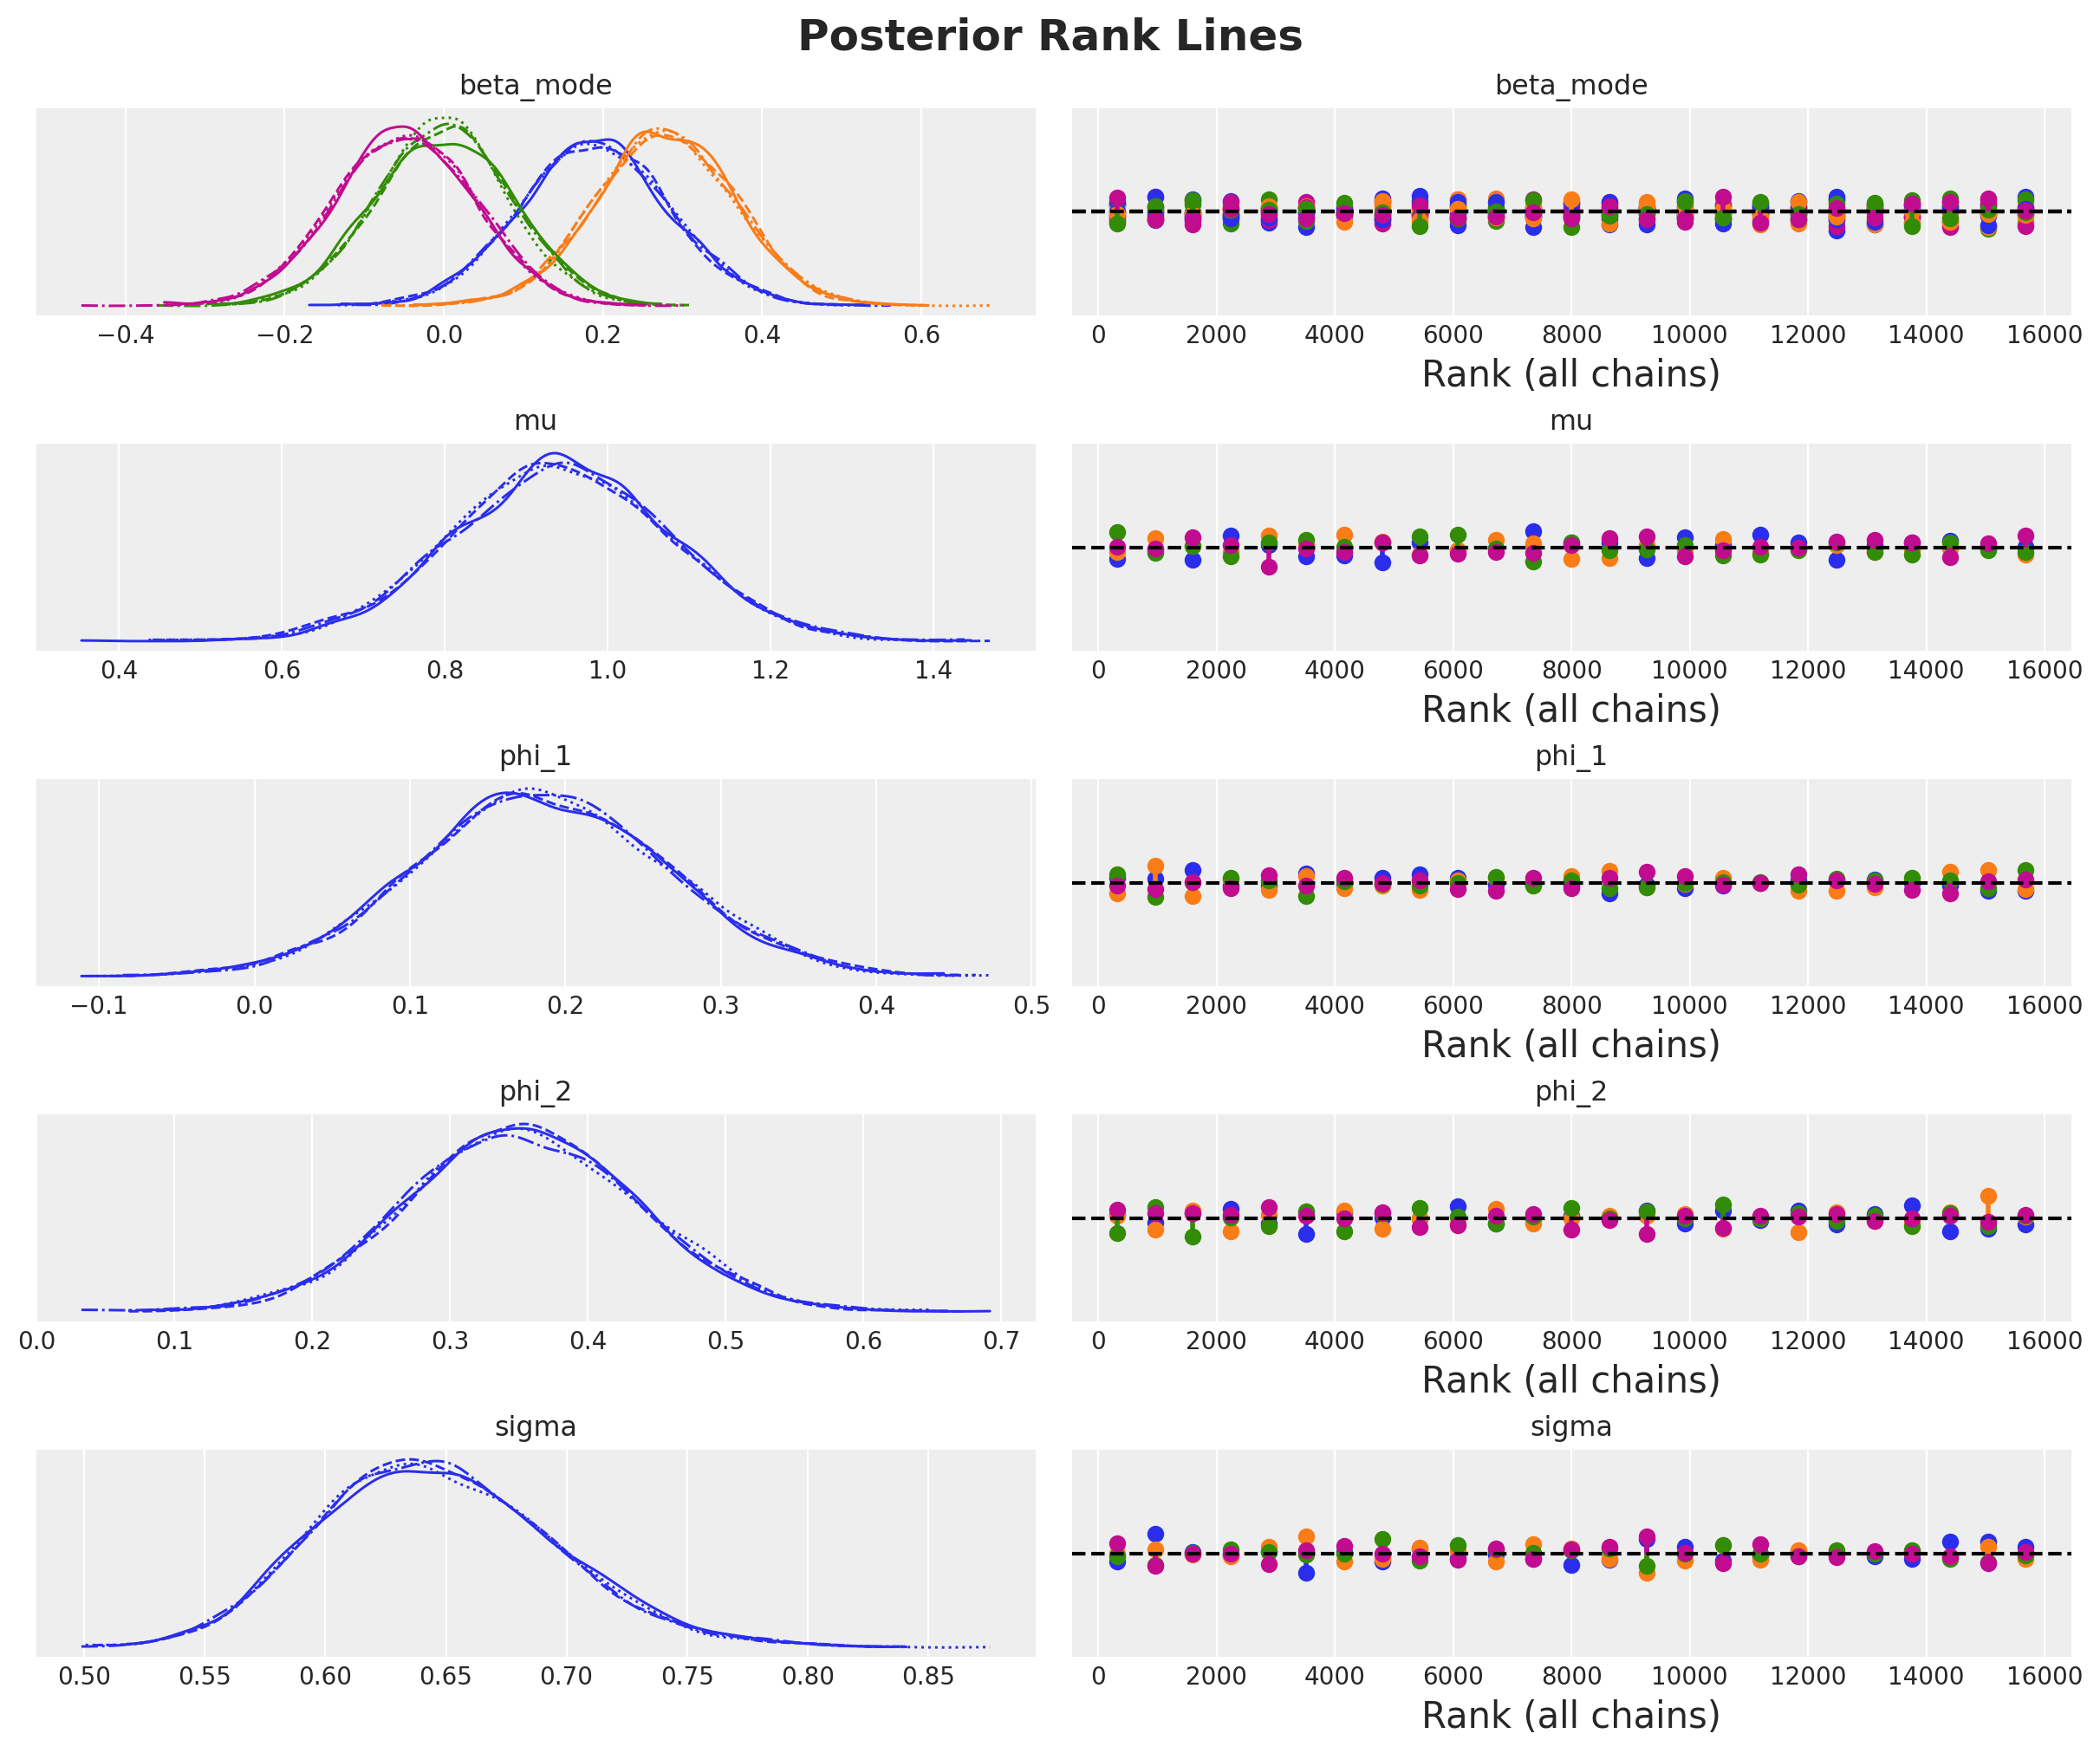

In [19]:
axes = az.plot_trace(
    data=idata,
    kind="rank_vlines",
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Posterior Rank Lines", fontsize=18, fontweight="bold");

Overall, the model seems to have converged well.

### Forecast

We are now ready to forecast the demand for the next $30$ days.

In [20]:
predictive = Predictive(
    model=ar2_seasonal,
    posterior_samples=mcmc.get_samples(),
    return_sites=["pred", "y_forecast"],
)

rng_key, rng_subkey = random.split(rng_key)
forecast = predictive(
    rng_subkey,
    y=sales_obs_train,
    censored=jnp.concat([max_capacity_train, max_capacity_test_expected], axis=0),
    is_available=jnp.concatenate([is_available_train, is_available_test_expected]),
    fourier_features=jnp.concatenate([fourier_features_train, fourier_features_test]),
    future=forecast_horizon,
)

We extend our inference object to store the forecast.

In [21]:
idata.extend(
    az.from_numpyro(
        posterior_predictive=forecast,
        coords={"t_test": t_test, "t": t[2:]},
        dims={"pred": ["t"], "y_forecast": ["t_test"]},
    )
)

We can now visualize the forecast and compare it with the classical ARIMA model above.

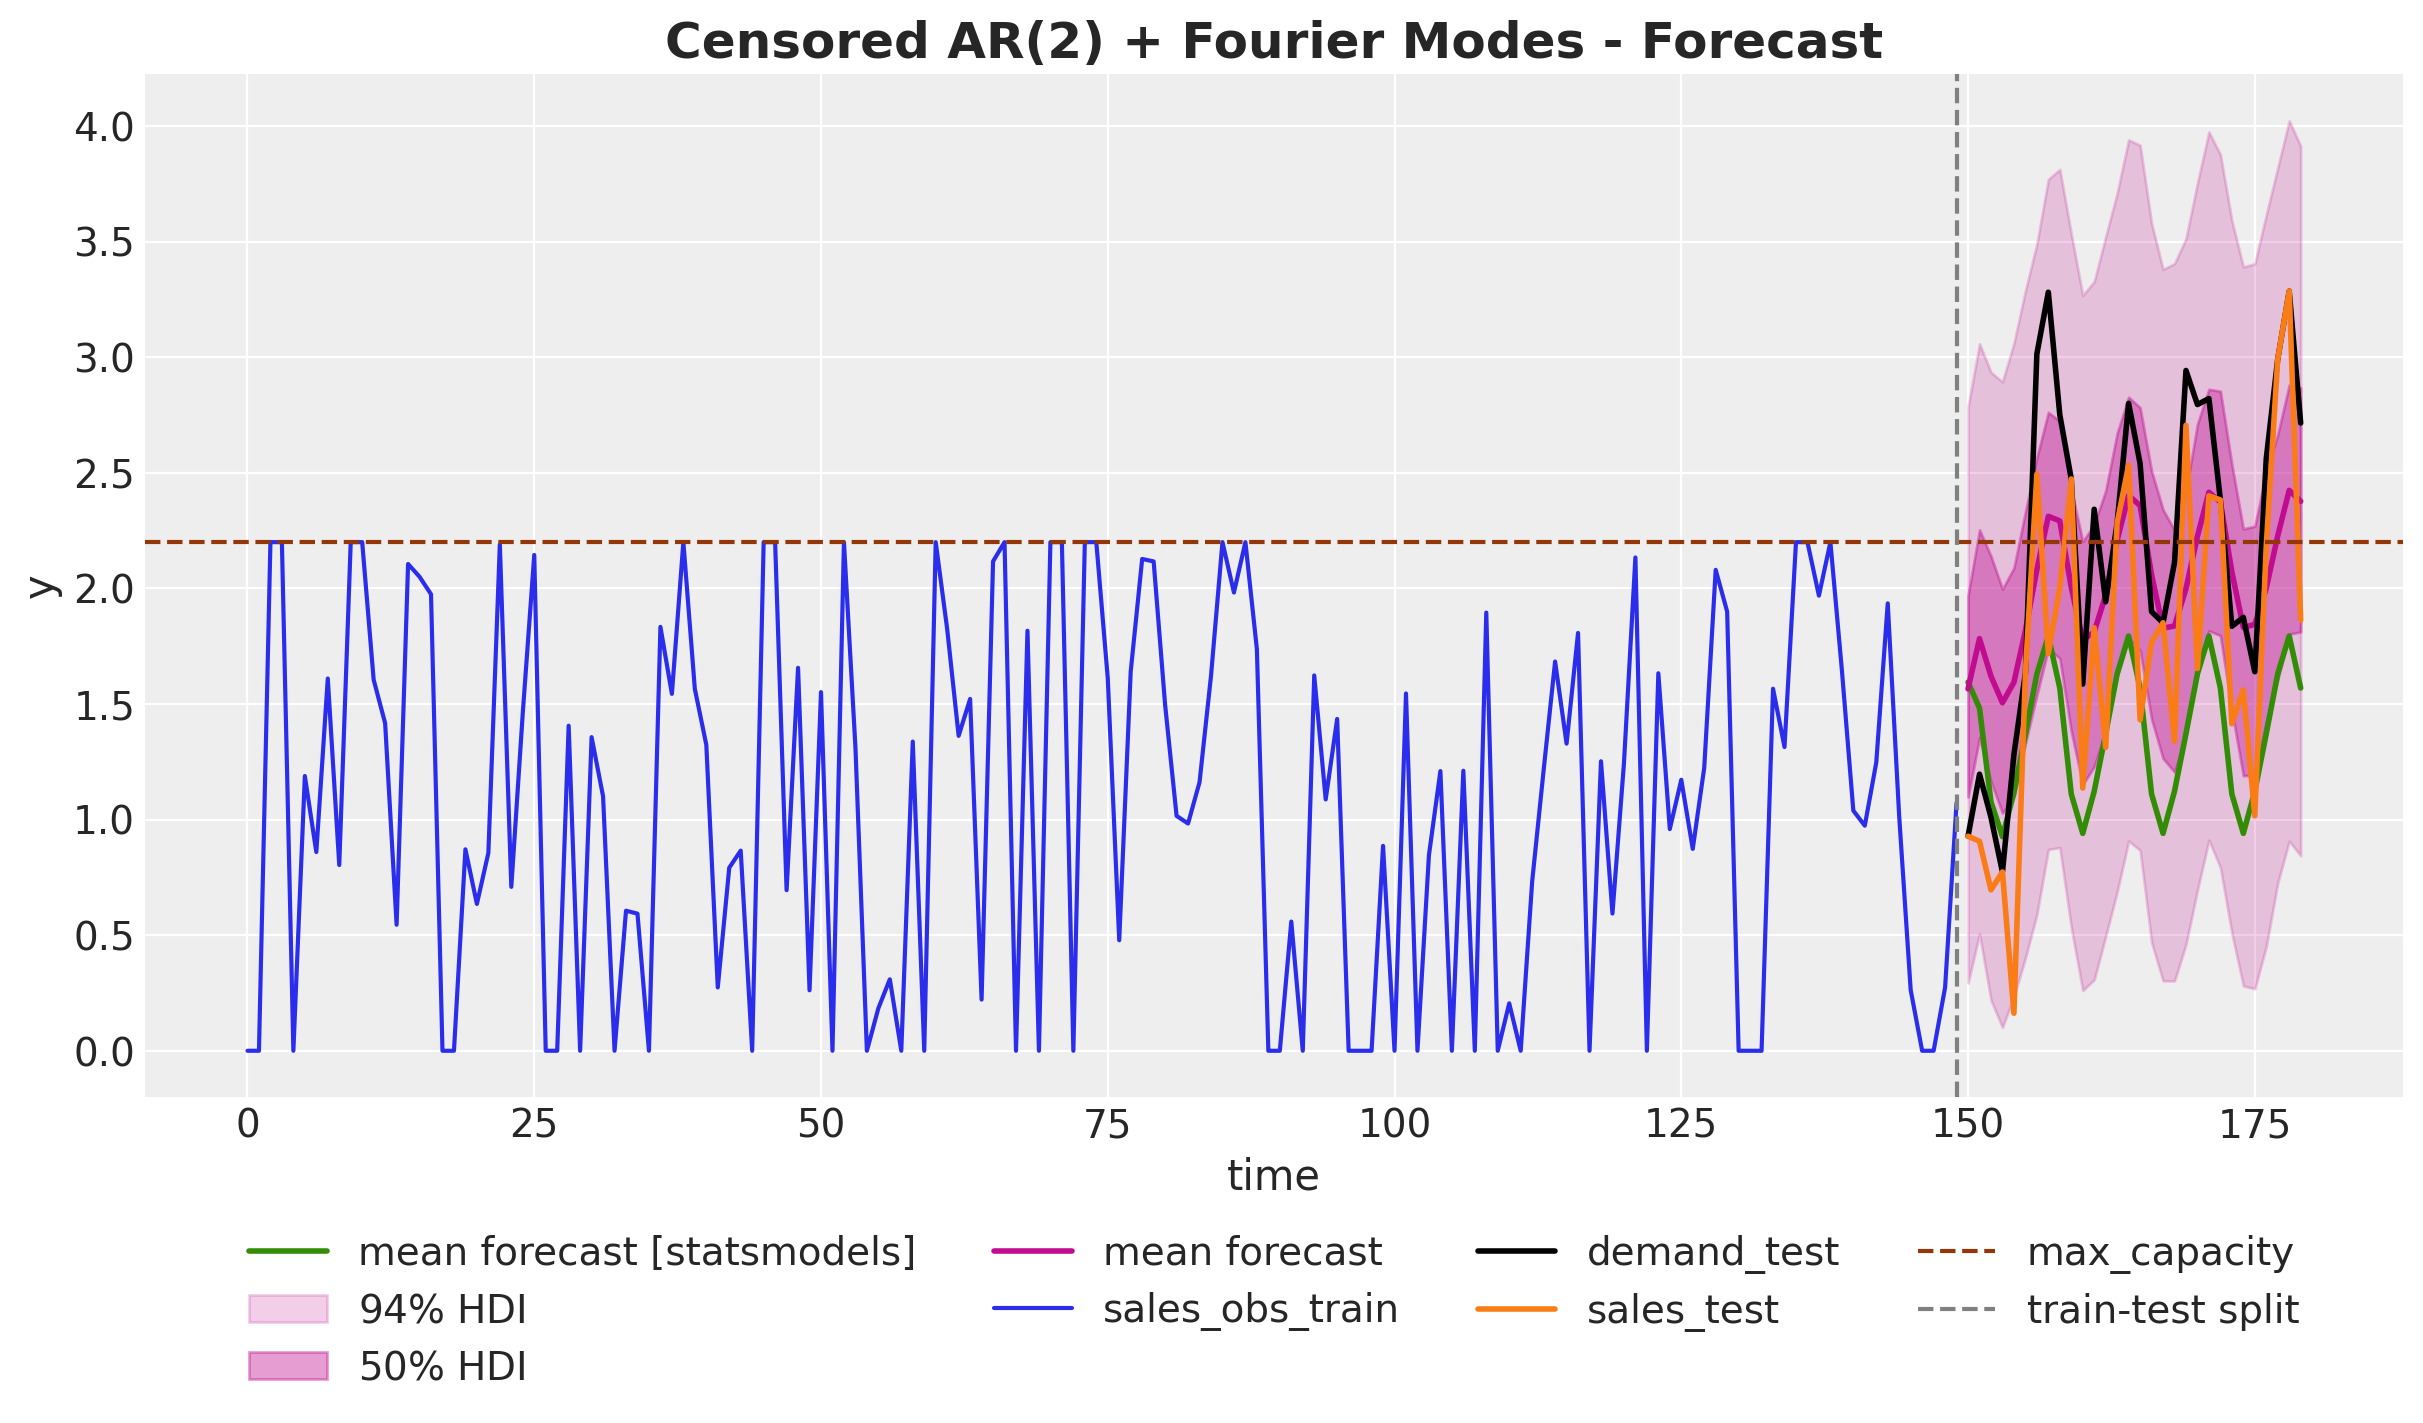

In [22]:
fig, ax = plt.subplots()
ax.plot(
    t_test,
    forecast_94_df["mean"],
    linewidth=2,
    color="C2",
    label="mean forecast [statsmodels]",
)
az.plot_hdi(
    t_test,
    idata.posterior_predictive["y_forecast"],
    smooth=False,
    hdi_prob=0.94,
    color="C3",
    fill_kwargs={"alpha": 0.2, "label": r"$94\%$ HDI"},
)
az.plot_hdi(
    t_test,
    idata.posterior_predictive["y_forecast"],
    smooth=False,
    hdi_prob=0.50,
    color="C3",
    fill_kwargs={"alpha": 0.4, "label": r"$50\%$ HDI"},
)
ax.plot(
    t_test,
    idata.posterior_predictive["y_forecast"].mean(dim=("chain", "draw")),
    linewidth=2,
    color="C3",
    label="mean forecast",
)
ax.plot(t_train, sales_obs_train, color="C0", label="sales_obs_train")
ax.plot(t_test, demand_test, color="black", linewidth=2, label="demand_test")
ax.plot(t_test, sales_test, color="C1", linewidth=2, label="sales_test")
ax.axhline(y=data_params.max_caparity, c="C4", linestyle="--", label="max_capacity")
ax.axvline(x=t_train[-1], c="gray", linestyle="--", label="train-test split")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
ax.set(xlabel="time", ylabel="y")
ax.set_title(
    "Censored AR(2) + Fourier Modes - Forecast", fontsize=18, fontweight="bold"
);

We clearly see that the mean forecast and the high-density-intervals (HDI) of censored likelihood model are much closer to the "raw" sales data and the demand. The reason is because we are allowing the model to consider points higher than the historical maximum capacity. The forecast of the censored model shows a good seasonality fit and a much better trend component estimation 🙂.

**Remark [Evaluation Metrics]**: If we treat this problem as a pure prediction problem, and compare the accuracy against a hold-out-set (test set), we probably always choose the classical ARIMA model as we are never seeing the true demand. However, if we consider the business problem, the censored likelihood model is much more useful as it provides a better estimate of the demand for planning and optimization purposes.